# Renda-Classificação

## Introdução

O objetivo desse projeto é prever a renda de um grupo familiar utilizando informações relacionadas a sua residência. Trata-se portanto de um projeto de **regressão supervisionado offline**. 

Uma aplicação possível desse projeto é como parte de um sistema de verificação de autodeclaração de renda. Esse sistema compararia a renda autodeclarada com a resposta do modelo de machine learning a fim de verificar a integridade desse dado.

Utilizaremos a métrica **MAE** (mean absolute error) para avaliar o nosso modelo. A justificativa para a escolha dessa métrica é que não desejamos penalizar exarcebadamente erros grandes. Preferimos que o nosso modelo seja mais preciso com rendas mais baixas e intermediárias.

## Extração dos dados

Os dados utilizados são do **Censo 2000** realizado pelo IBGE e mantido na [Base dos Dados](https://basedosdados.org/dataset/br-ibge-censo-demografico?bdm_table=microdados_domicilio_2000). Informações sobre a metodologia do Censo e sobre a base de dados estão na pasta `materiais`. A extração será realizada utilizando SQL utilizando a API do **BigQuery**.

In [140]:
# # Consulta

# import os
# import pandas as pd
# from google.cloud import bigquery

# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'renda-censo-regressao-0d5cd82b3cac.json'

# client = bigquery.Client()

# query = """
#         SELECT sigla_uf, situacao_domicilio, v0202 AS tipo_domicilio, v0205 AS condicao_domicilio, v0203 AS comodos, v0204 AS dormitorios,v0209 AS banheiros, v0207 AS agua, v0213 AS iluminacao, v0214 AS radio, v0215 AS geladeira, v0216 AS videocassete, v0217 AS maquina_lavar, v0218 AS microondas, v0219 as telefone, v0220 as computador, v0221 as televisores, v0222 as automoveis, v0223 as ar_condicionado, v0212 AS coleta_lixo, v7100 AS moradores, v0110 AS homens, v0111 AS mulheres, v7616 AS rendimento
#         FROM `basedosdados.br_ibge_censo_demografico.microdados_domicilio_2000`
#         WHERE (v7616 IS NOT NULL) AND (v7616 > 0) AND (v7616 < 100000) AND v0201 = 1
#         ORDER BY RAND() 
#         LIMIT 100000;
#         """

# df_raw = client.query(query).to_dataframe()
# df_raw.to_csv('data/df_raw.csv', index=False)

# df_raw.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,telefone,computador,televisores,automoveis,ar_condicionado,coleta_lixo,moradores,homens,mulheres,rendimento
0,CE,1,1,1,3,2,0,2,1,1,...,2,2,1,0,0,5,5,3,2,240
1,GO,1,1,1,6,3,1,1,1,1,...,1,2,1,0,0,1,3,1,2,660
2,SP,1,2,1,5,2,1,1,1,1,...,1,1,2,1,0,1,3,1,2,3100
3,SP,1,1,1,6,2,1,1,1,1,...,1,1,2,0,0,1,6,1,5,1980
4,PE,1,1,1,4,2,1,1,1,2,...,2,2,1,0,0,1,13,4,9,391


## Colunas

Coluna       | Tipo  | Descrição
-------------|-------|-------------------------------
sigla_uf     |str    | Sigla da Unidade da Federação
situacao_domicilio | int64 | 1: Urbano, 2: Rural
tipo_domicilio | int64 | 1: Casa, 2: Apartamento, 3: Cômodo
condicao_domicilio | int64 | 1: proprio pago, 2: proprio pagando, 3: alugado, 4: cedido por empregador, 5: cedido, 6: outro
comodos | int64 | Número de cômodos
dormitorios | int64 | Número de dormitórios
banheiros | int64 | Número de banheiros
agua | int64 | 1: rede geral, 2: Poço, 3: outro
iluminacao | int64 | 1: sim, 2: não
radio | int64 | Número de rádios
geladeira | int64 | Número de geladeiras
videocassete | int64 | Número de videocassetes
maquina_lavar | int64 | Número de máquinas de lavar
microondas | int64 | Número de microondas
telefone | int64 | Número de telefones
computador | int64 | Número de computadores
televisores | int64 | Número de televisores
automoveis | int64 | Número de automoveis 
ar_condicionado | int64 | Número de ar-condicionado
coleta_lixo | int64 | 1: serviço de limpeza, 2: caçamba, 3: queimado, 4: enterrado, 5: aterro, 6: rio, 7: outro
moradores | int64 | Número de moradores
homens | int64 | Número de homens residentes
mulheres | int64 | Número de mulheres residentes
rendimento | int64 | Total de rendimentos (Target)

## Explorando os dados

In [223]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from skopt import dummy_minimize, gp_minimize

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [142]:
df_raw = pd.read_csv('data/df_raw.csv')

In [143]:
df_raw.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,telefone,computador,televisores,automoveis,ar_condicionado,coleta_lixo,moradores,homens,mulheres,rendimento
0,CE,1,1,1,3,2,0,2,1,1,...,2,2,1,0,0,5,5,3,2,240
1,GO,1,1,1,6,3,1,1,1,1,...,1,2,1,0,0,1,3,1,2,660
2,SP,1,2,1,5,2,1,1,1,1,...,1,1,2,1,0,1,3,1,2,3100
3,SP,1,1,1,6,2,1,1,1,1,...,1,1,2,0,0,1,6,1,5,1980
4,PE,1,1,1,4,2,1,1,1,2,...,2,2,1,0,0,1,13,4,9,391


In [144]:
df_raw.shape

(100000, 24)

In [145]:
df_raw.isna().sum()

sigla_uf              0
situacao_domicilio    0
tipo_domicilio        0
condicao_domicilio    0
comodos               0
dormitorios           0
banheiros             0
agua                  0
iluminacao            0
radio                 0
geladeira             0
videocassete          0
maquina_lavar         0
microondas            0
telefone              0
computador            0
televisores           0
automoveis            0
ar_condicionado       0
coleta_lixo           0
moradores             0
homens                0
mulheres              0
rendimento            0
dtype: int64

In [146]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   sigla_uf            100000 non-null  object
 1   situacao_domicilio  100000 non-null  int64 
 2   tipo_domicilio      100000 non-null  int64 
 3   condicao_domicilio  100000 non-null  int64 
 4   comodos             100000 non-null  int64 
 5   dormitorios         100000 non-null  int64 
 6   banheiros           100000 non-null  int64 
 7   agua                100000 non-null  int64 
 8   iluminacao          100000 non-null  int64 
 9   radio               100000 non-null  int64 
 10  geladeira           100000 non-null  int64 
 11  videocassete        100000 non-null  int64 
 12  maquina_lavar       100000 non-null  int64 
 13  microondas          100000 non-null  int64 
 14  telefone            100000 non-null  int64 
 15  computador          100000 non-null  int64 
 16  tel

In [73]:
df_raw.describe()

,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,geladeira,...,telefone,computador,televisores,automoveis,ar_condicionado,coleta_lixo,moradores,homens,mulheres,rendimento
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.204540,1.10307,1.758990,5.720480,2.032370,1.094080,1.316350,1.061310,1.122590,1.175430,...,1.63227,1.902710,1.280740,0.400080,0.104430,1.773680,3.869210,1.910470,1.958740,1091.594460
std,0.403367,0.33566,1.288061,2.360687,0.875403,0.815019,0.593192,0.239899,0.327968,0.380336,...,0.48219,0.296354,0.896344,0.647441,0.460659,1.401356,1.974726,1.281644,1.225958,2643.502251
min,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,1.000000,1.00000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,2.000000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,280.000000
50%,1.000000,1.00000,1.000000,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.00000,2.000000,1.000000,0.000000,0.000000,1.000000,4.000000,2.000000,2.000000,519.000000
75%,1.000000,1.00000,2.000000,7.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.00000,2.000000,2.000000,1.000000,0.000000,2.000000,5.000000,3.000000,3.000000,1100.000000
max,2.000000,3.00000,6.000000,30.000000,9.000000,9.000000,3.000000,2.000000,2.000000,2.000000,...,2.00000,2.000000,9.000000,7.000000,9.000000,7.000000,29.000000,16.000000,16.000000,301810.000000


## Pre-processamento

In [147]:
df = df_raw.copy()

In [148]:
df['situacao_domicilio'] = df_raw['situacao_domicilio'].map({1:'urbano', 2:'rural'})

In [149]:
df['tipo_domicilio'] = df_raw['tipo_domicilio'].map({1:'casa', 2:'apartamento', 3:'comodo'})

In [150]:
df['condicao_domicilio'] = df_raw['condicao_domicilio'].map({1:'proprio pago',
                                                             2:'proprio pagando',
                                                             3:'alugado',
                                                             4:'cedido por empregador',
                                                             5:'cedido',
                                                             6:'outro'})

In [151]:
df['agua'] = df_raw['agua'].map({1:'rede geral',
                                 2:'poço',
                                 3:'outro'})

In [152]:
df['iluminacao'] = df_raw['iluminacao'].map({1:'sim',
                                             2:'não'})

In [153]:
df['coleta_lixo'] = df_raw['coleta_lixo'].map({1:'serviço de limpeza',
                                               2:'caçamba',
                                               3:'queimado',
                                               4:'enterrado',
                                               5:'aterro',
                                               6:'rio',
                                               7:'outro'})

In [154]:
df.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,telefone,computador,televisores,automoveis,ar_condicionado,coleta_lixo,moradores,homens,mulheres,rendimento
0,CE,urbano,casa,proprio pago,3,2,0,poço,sim,1,...,2,2,1,0,0,aterro,5,3,2,240
1,GO,urbano,casa,proprio pago,6,3,1,rede geral,sim,1,...,1,2,1,0,0,serviço de limpeza,3,1,2,660
2,SP,urbano,apartamento,proprio pago,5,2,1,rede geral,sim,1,...,1,1,2,1,0,serviço de limpeza,3,1,2,3100
3,SP,urbano,casa,proprio pago,6,2,1,rede geral,sim,1,...,1,1,2,0,0,serviço de limpeza,6,1,5,1980
4,PE,urbano,casa,proprio pago,4,2,1,rede geral,sim,2,...,2,2,1,0,0,serviço de limpeza,13,4,9,391


In [155]:
# Train-Test Split

X = df.drop('rendimento', axis=1)
y = df['rendimento']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11111, random_state=42)

In [156]:
print(f'train: {y_train.shape[0]}, validation: {y_val.shape[0]}, test: {y_test.shape[0]}')

train: 80000, validation: 10000, test: 10000


## EDA

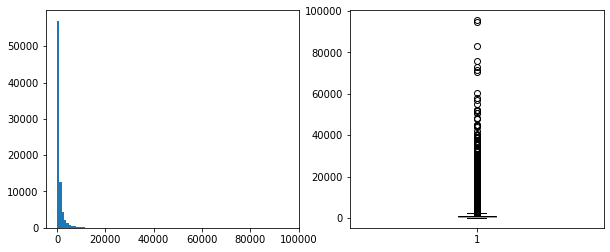

In [157]:
# O target é extremamente assimétrico

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(y_train, bins=100)

plt.subplot(1,2,2)
plt.boxplot(y_train)

plt.show()

In [158]:
y_train.describe()

count    80000.000000
mean      1081.719850
std       2127.363233
min          4.000000
25%        282.000000
50%        511.000000
75%       1082.000000
max      95500.000000
Name: rendimento, dtype: float64

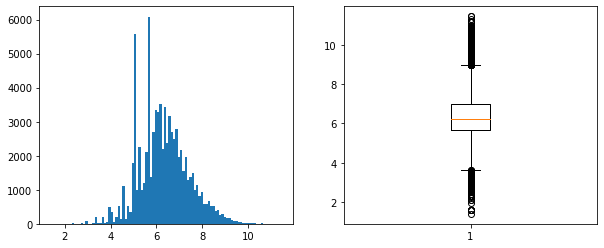

In [159]:
# O target é extremamente assimétrico

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(np.log(y_train), bins=100)

plt.subplot(1,2,2)
plt.boxplot(np.log(y_train))

plt.show()

### sigla_uf

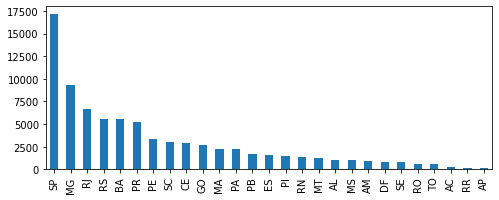

In [160]:
plt.figure(figsize=(8,3))
X_train['sigla_uf'].value_counts().plot(kind='bar')
plt.show()

In [161]:
X_train.join(y_train)[['sigla_uf', 'rendimento']].groupby('sigla_uf').median().sort_values(by='rendimento', ascending=False)

,rendimento
sigla_uf,
DF,968.5
SP,821.0
RJ,750.0
SC,700.0
RS,628.0
AP,604.0
RR,590.0
PR,550.0
MT,550.0


### situacao_domicilio

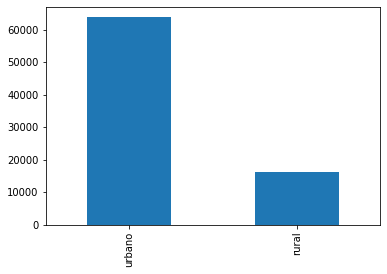

In [162]:
X_train['situacao_domicilio'].value_counts().plot(kind='bar')
plt.show()

In [163]:
X_train.join(y_train).groupby('situacao_domicilio').median().sort_values(by='rendimento', ascending=False)

,comodos,dormitorios,banheiros,radio,geladeira,videocassete,maquina_lavar,microondas,telefone,computador,televisores,automoveis,ar_condicionado,moradores,homens,mulheres,rendimento
situacao_domicilio,,,,,,,,,,,,,,,,,
urbano,5.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,4.0,2.0,2.0,602.0
rural,5.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,4.0,2.0,2.0,300.0


### condicao_domicilio

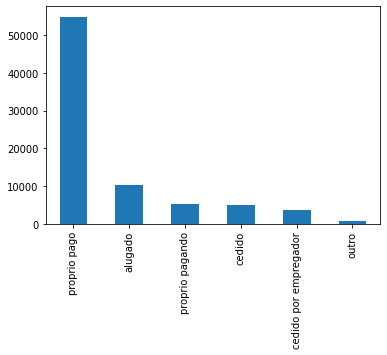

In [164]:
X_train['condicao_domicilio'].value_counts().plot(kind='bar')
plt.show()

In [165]:
X_train.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,microondas,telefone,computador,televisores,automoveis,ar_condicionado,coleta_lixo,moradores,homens,mulheres
68111,RJ,urbano,casa,proprio pago,4,1,1,rede geral,sim,1,...,2,2,2,1,0,0,serviço de limpeza,4,1,3
44812,PI,urbano,casa,proprio pago,6,2,1,rede geral,sim,1,...,2,2,2,1,0,0,serviço de limpeza,4,1,3
76085,RJ,urbano,casa,alugado,2,1,1,outro,sim,1,...,2,2,2,0,0,0,serviço de limpeza,1,1,0
37522,RS,urbano,casa,outro,3,2,1,rede geral,sim,1,...,2,2,2,1,0,0,serviço de limpeza,5,1,4
11556,PE,urbano,casa,proprio pago,6,2,1,rede geral,sim,1,...,2,2,2,2,0,0,serviço de limpeza,4,1,3


### tipo_domicilio

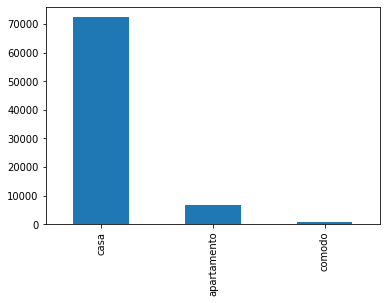

In [166]:
X_train['tipo_domicilio'].value_counts().plot(kind='bar')
plt.show()

In [167]:
X_train.join(y_train).groupby('tipo_domicilio').median().sort_values(by='rendimento', ascending=False)

,comodos,dormitorios,banheiros,radio,geladeira,videocassete,maquina_lavar,microondas,telefone,computador,televisores,automoveis,ar_condicionado,moradores,homens,mulheres,rendimento
tipo_domicilio,,,,,,,,,,,,,,,,,
apartamento,6.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,3.0,1.0,1.0,1800.0
casa,5.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,4.0,2.0,2.0,490.0
comodo,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,1.0,1.0,300.0


### comodos

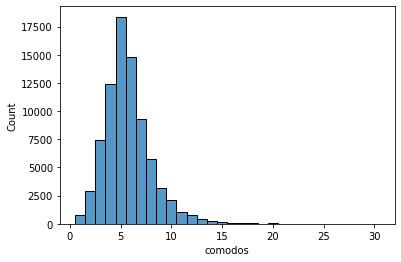

In [168]:
sns.histplot(data=X_train, x='comodos', discrete=True);

In [169]:
X_train['comodos'].describe()

count    80000.000000
mean         5.728413
std          2.359337
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         30.000000
Name: comodos, dtype: float64

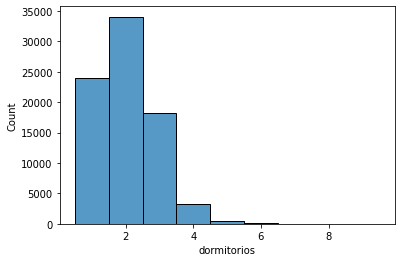

In [264]:
sns.histplot(data=X_train, x='dormitorios', discrete=True);

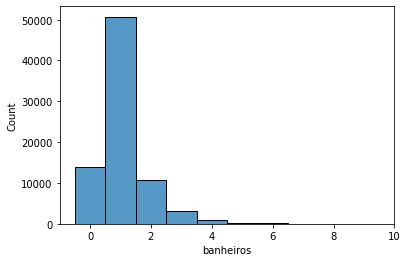

In [266]:
sns.histplot(data=X_train, x='banheiros', discrete=True);

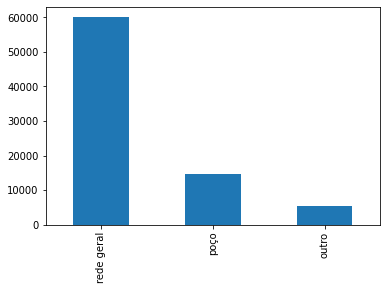

In [267]:
X_train['agua'].value_counts().plot(kind='bar')
plt.show()

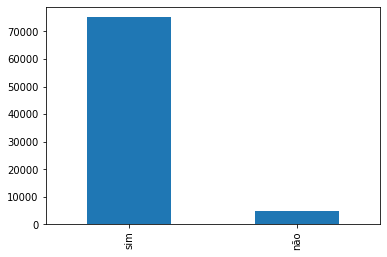

In [268]:
X_train['iluminacao'].value_counts().plot(kind='bar')
plt.show()

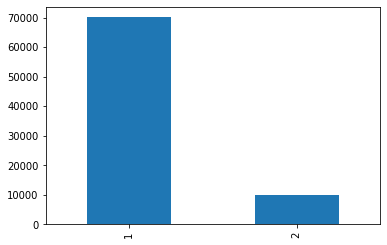

In [270]:
X_train['radio'].value_counts().plot(kind='bar')
plt.show()

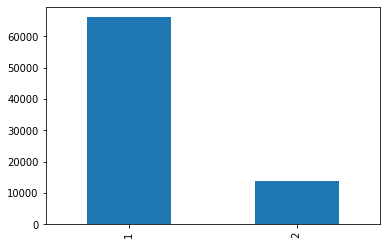

In [272]:
X_train['geladeira'].value_counts().plot(kind='bar')
plt.show()

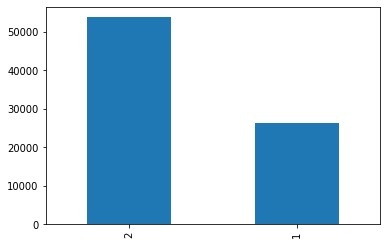

In [274]:
X_train['videocassete'].value_counts().plot(kind='bar')
plt.show()

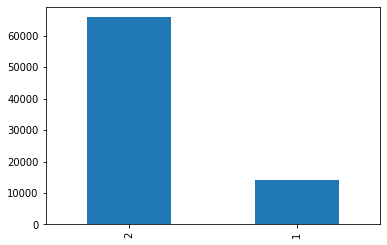

In [276]:
X_train['microondas'].value_counts().plot(kind='bar')
plt.show()

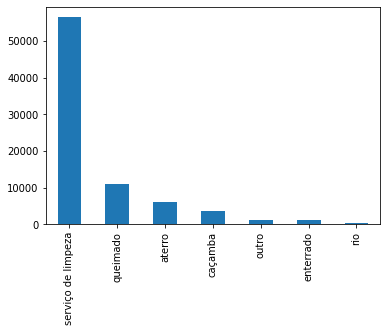

In [282]:
X_train['coleta_lixo'].value_counts().plot(kind='bar')
plt.show()

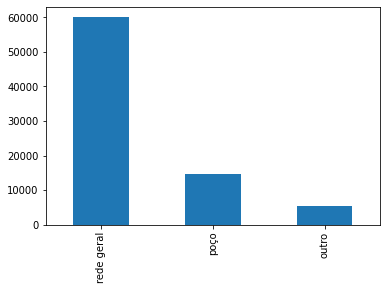

In [283]:
X_train['agua'].value_counts().plot(kind='bar')
plt.show()

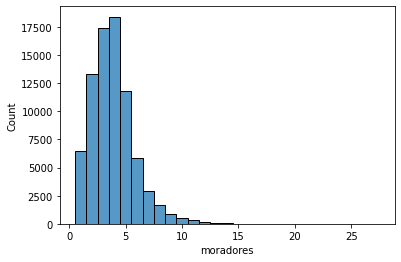

In [278]:
sns.histplot(data=X_train, x='moradores', discrete=True);

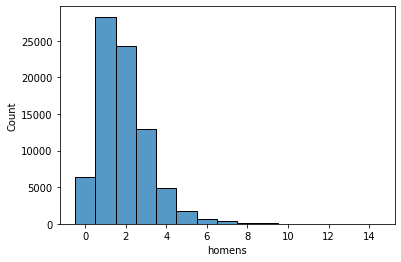

In [279]:
sns.histplot(data=X_train, x='homens', discrete=True);

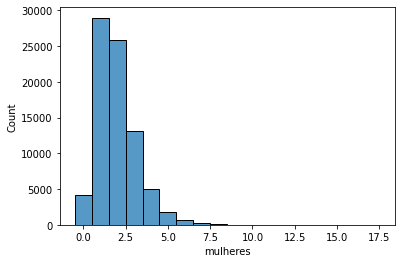

In [280]:
sns.histplot(data=X_train, x='mulheres', discrete=True);

## Correlações

rendimento         1.000000
automoveis         0.480357
banheiros          0.471861
televisores        0.424147
comodos            0.391006
ar_condicionado    0.324247
dormitorios        0.180411
mulheres           0.014766
moradores          0.013705
homens             0.006924
radio             -0.105171
geladeira         -0.171128
maquina_lavar     -0.333267
videocassete      -0.340037
telefone          -0.345259
microondas        -0.381548
computador        -0.418388
Name: rendimento, dtype: float64


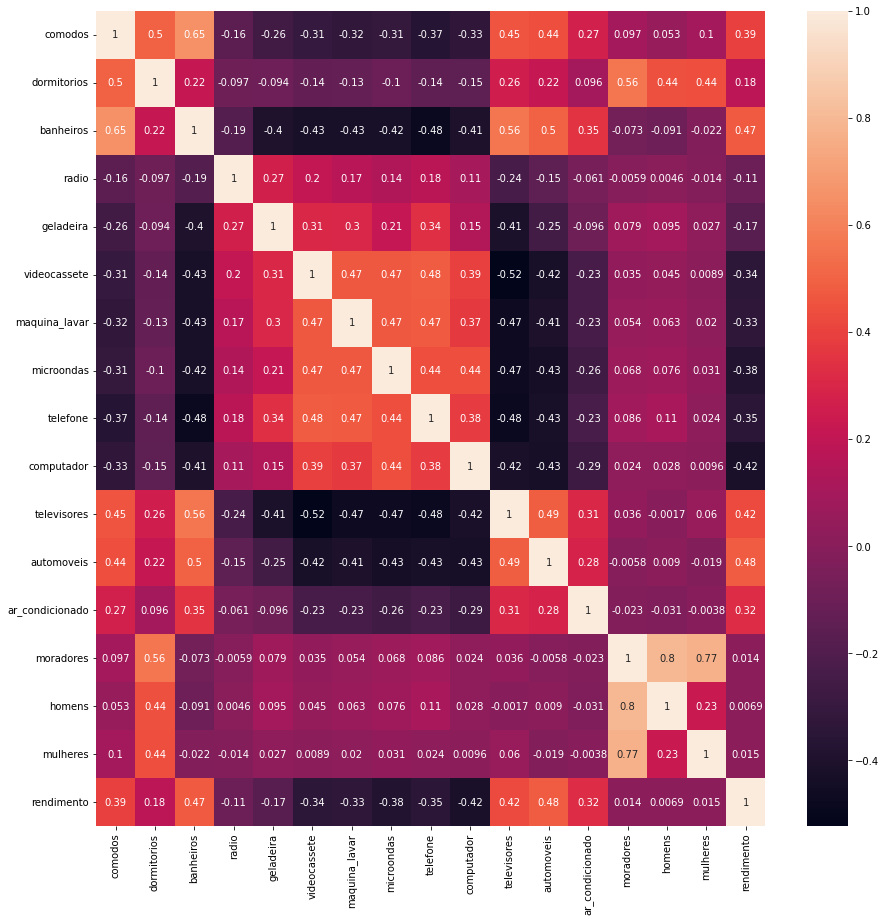

In [170]:
corr = X_train.join(y_train).corr()

plt.figure(figsize=(15,15))
sns.heatmap(data=corr, annot=True);

print(corr['rendimento'].sort_values(ascending=False))

## Baseline

In [171]:
X_train.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,microondas,telefone,computador,televisores,automoveis,ar_condicionado,coleta_lixo,moradores,homens,mulheres
68111,RJ,urbano,casa,proprio pago,4,1,1,rede geral,sim,1,...,2,2,2,1,0,0,serviço de limpeza,4,1,3
44812,PI,urbano,casa,proprio pago,6,2,1,rede geral,sim,1,...,2,2,2,1,0,0,serviço de limpeza,4,1,3
76085,RJ,urbano,casa,alugado,2,1,1,outro,sim,1,...,2,2,2,0,0,0,serviço de limpeza,1,1,0
37522,RS,urbano,casa,outro,3,2,1,rede geral,sim,1,...,2,2,2,1,0,0,serviço de limpeza,5,1,4
11556,PE,urbano,casa,proprio pago,6,2,1,rede geral,sim,1,...,2,2,2,2,0,0,serviço de limpeza,4,1,3


In [172]:
# Tratamento

ohe = OneHotEncoder(drop='first')
ohe_ct = ColumnTransformer(transformers=[('ohe', ohe, [0,1,2,3,7,8,19])], remainder='passthrough')
std_scaler = StandardScaler()
tr_pipeline = Pipeline([('ohe_ct', ohe_ct), ('scale', std_scaler)])

tr_pipeline

Pipeline(steps=[('ohe_ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  [0, 1, 2, 3, 7, 8, 19])])),
                ('scale', StandardScaler())])

In [173]:
X_train_tr = tr_pipeline.fit_transform(X_train)
X_val_tr = tr_pipeline.transform(X_val)

In [174]:
forest_reg = RandomForestRegressor(random_state=42,
                                  n_jobs=-1)

forest_reg.fit(X_train_tr, y_train)
y_pred = forest_reg.predict(X_val_tr)

print('MAE: ', mean_absolute_error(y_val, y_pred))

2079.6214453898237

## Análises do erro

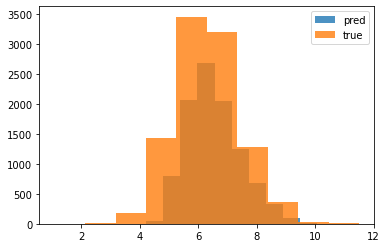

In [177]:
plt.hist(np.log(y_pred),alpha=0.8, label='pred')
plt.hist(np.log(y_val),alpha=0.8, label='true')
plt.legend()
plt.show()

In [178]:
pd.Series(y_pred).describe()

count    10000.000000
mean      1119.259243
std       1526.189003
min         68.460000
25%        360.776498
50%        623.827500
75%       1205.443125
max      23612.930000
dtype: float64

In [179]:
y_train.describe()

count    80000.000000
mean      1081.719850
std       2127.363233
min          4.000000
25%        282.000000
50%        511.000000
75%       1082.000000
max      95500.000000
Name: rendimento, dtype: float64

# Tratamento dos dados

## Tratamento de outliers

In [181]:
# Método tradicional

y_train_tr = y_train.copy()

Q1 = np.percentile(y_train, 25)
Q3 = np.percentile(y_train, 75)

iqr = Q3 - Q1

upper_bound = iqr + (1.5 * iqr)
lower_bound = iqr - (1.5 * iqr)

y_train_tr.loc[y_train > upper_bound] = upper_bound
y_train_tr.loc[y_train < lower_bound] = lower_bound

forest_reg = RandomForestRegressor(random_state=42,
                                   n_jobs=-1)

forest_reg.fit(X_train_tr, np.log(y_train_tr))
y_pred = forest_reg.predict(X_val_tr)

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  638.7242575326918


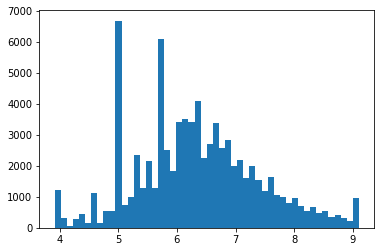

In [183]:
# Método alternativo

y_train_tr = y_train.copy()

upper_bound = np.percentile(y_train_tr, 99)
lower_bound = np.percentile(y_train_tr, 1)

y_train_tr.loc[y_train > upper_bound] = upper_bound
y_train_tr.loc[y_train < lower_bound] = lower_bound

plt.hist(np.log(y_train_tr), bins=50)
plt.show()

In [184]:
forest_reg = RandomForestRegressor(random_state=42,
                                   n_jobs=-1)

forest_reg.fit(X_train_tr, np.log(y_train_tr))
y_pred = forest_reg.predict(X_val_tr)

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  583.3711173500203


## Feature engineering

In [185]:
X_train_feature = X_train.copy()
X_val_feature = X_val.copy()

In [186]:
X_train_feature['moradores_por_comodo'] = X_train['moradores'] / X_train['comodos']
X_train_feature['moradores_por_dormitorio'] = X_train['moradores'] / X_train['dormitorios']

X_val_feature['moradores_por_comodo'] = X_val['moradores'] / X_val['comodos']
X_val_feature['moradores_por_dormitorio'] = X_val['moradores'] / X_val['dormitorios']

In [187]:
X_train_feature_tr = tr_pipeline.fit_transform(X_train_feature)
X_val_feature_tr = tr_pipeline.transform(X_val_feature)

In [188]:
forest_reg = RandomForestRegressor(random_state=42,
                                   n_jobs=-1)

forest_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = forest_reg.predict(X_val_feature_tr)

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  583.1957306521583


# Refinando modelos

In [191]:
forest_reg = RandomForestRegressor(n_estimators=500,
                                   random_state=42,
                                   n_jobs=-1)

forest_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = forest_reg.predict(X_val_feature_tr)

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  581.2982138023982


In [192]:
xgb_reg = XGBRegressor(n_estimators=500,
                       learning_rate=0.01,
                       n_jobs=-1,
                       random_state=42)

xgb_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = xgb_reg.predict(X_val_feature_tr)

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  559.755457862091


In [211]:
lgbm_reg = LGBMRegressor(n_estimators=300,
                         n_jobs=-1, 
                         random_state=42)

lgbm_reg.fit(X_train_feature_tr, np.log(y_train_tr))
y_pred = lgbm_reg.predict(X_val_feature_tr)

print('MAE: ', mean_absolute_error(y_val, np.exp(y_pred)))

MAE:  552.8241082732466


# Otimização de hiperparâmetros

In [220]:
# Random search

def treinar_modelo(params):
     
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params)
    
    lgbm_reg = LGBMRegressor(n_estimators=500,
                             learning_rate=learning_rate,
                             num_leaves = num_leaves,
                             min_child_samples = min_child_samples,
                             subsample = subsample,
                             colsample_bytree = colsample_bytree,
                             subsample_freq=1,
                             n_jobs=-1, 
                             random_state=42)
    
    lgbm_reg.fit(X_train_feature_tr, np.log(y_train_tr))
    y_pred = lgbm_reg.predict(X_val_feature_tr)
    
    return mean_absolute_error(y_val, np.exp(y_pred))

space = [(1e-3, 1e-1), # learning_rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0) # colsample_bytree
        ]

resultado = dummy_minimize(treinar_modelo, space, random_state=42, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[0.07985775569916306, 16, 72, 0.6187255599871848, 0.2404167763981929]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.6828
Function value obtained: 552.3444
Current minimum: 552.3444
Iteration No: 2 started. Evaluating function at random point.
[0.016443457513284066, 76, 75, 0.8728673384861885, 0.6410035105688879]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.3769
Function value obtained: 551.7266
Current minimum: 551.7266
Iteration No: 3 started. Evaluating function at random point.
[0.07109918520180852, 23, 53, 0.9714143595538948, 0.8491983767203797]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.6244
Function value obtained: 551.8810
Current minimum: 551.7266
Iteration No: 4 started. Evaluating function at random point.
[0.022021571957149343, 65, 60, 0.22423428436076215, 0.373818018663584]
Iteration No: 4 ended. Evaluation done at random point.
Time take

In [222]:
best_result = resultado.x

In [225]:
# Baysean optimization

resultado = gp_minimize(treinar_modelo, space, random_state=42, verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.07985775569916308, 25, 78, 0.6170076500491628, 0.5012494775682321]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.9596
Function value obtained: 551.4408
Current minimum: 551.4408
Iteration No: 2 started. Evaluating function at random point.
[0.01089751666598229, 60, 34, 0.18572347702584374, 0.6857996256539677]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.3750
Function value obtained: 553.4044
Current minimum: 551.4408
Iteration No: 3 started. Evaluating function at random point.
[0.006584746323682927, 93, 94, 0.05073982754896361, 0.992990403362096]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.5598
Function value obtained: 566.6552
Current minimum: 551.4408
Iteration No: 4 started. Evaluating function at random point.
[0.06213066945314395, 79, 2, 0.07190930378934497, 0.5722971942325503]
Iteration No: 4 ended. Evaluation done at random point.
Time take

In [226]:
resultado.x

[0.07985775569916308, 25, 78, 0.6170076500491628, 0.5012494775682321]

# Resultados finais

In [259]:
lgbm_reg = LGBMRegressor(n_estimators=500,
                         learning_rate=0.08,
                         num_leaves=25,
                         min_child_samples = 80,
                         subsample = 0.6,
                         colsample_bytree=0.5,
                         subsample_freq=1,
                         n_jobs=-1, 
                         random_state=42)

lgbm_reg.fit(X_train_feature_tr, np.log(y_train_tr))

y_pred = lgbm_reg.predict(X_val_feature_tr)

In [260]:
# Métricas de treino

mae = mean_absolute_error(y_val, np.exp(y_pred))
mape = mean_absolute_percentage_error(y_val, np.exp(y_pred))
rmse = np.sqrt(mean_squared_error(y_val, np.exp(y_pred)))
r2 = r2_score(y_val, np.exp(y_pred))

pd.DataFrame([{'Model':'LGBM (Treino)','MAE': mae, 'MAPE':mape, 'RMSE':rmse, 'R2':r2}])

,Model,MAE,MAPE,RMSE,R2
0,LGBM (Treino),551.399686,0.65419,2022.338668,0.277198


In [261]:
# Tratamento do teste

X_test_feature = X_test.copy()

In [262]:
# Métricas de teste

X_test_feature['moradores_por_comodo'] = X_test['moradores'] / X_test['comodos']
X_test_feature['moradores_por_dormitorio'] = X_test['moradores'] / X_test['dormitorios']


X_test_feature_tr = tr_pipeline.transform(X_test_feature)

y_pred = lgbm_reg.predict(X_test_feature_tr)

mae = mean_absolute_error(y_test, np.exp(y_pred))
mape = mean_absolute_percentage_error(y_test, np.exp(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, np.exp(y_pred)))
r2 = r2_score(y_test, np.exp(y_pred))

pd.DataFrame([{'Model':'LGBM (Teste)','MAE': mae, 'MAPE':mape, 'RMSE':rmse, 'R2':r2}])

,Model,MAE,MAPE,RMSE,R2
0,LGBM (Teste),503.889469,0.645168,1284.884388,0.461854


In [286]:
# Intevalo de confiança

from scipy import stats

confidence = 0.95
absolute_errors = np.abs(np.exp(y_pred) - y_test)
stats.t.interval(confidence, len(squared_errors) - 1,
                loc=absolute_errors.mean(),
                scale=stats.sem(absolute_errors))

(480.7195667550926, 527.0593715354455)